In [23]:
import numpy as np
import scipy.sparse as sp
import torch

This directory contains the a selection of the Cora dataset (www.research.whizbang.com/data).

The Cora dataset consists of Machine Learning papers. These papers are classified into one of the following seven classes:
		Case_Based
		Genetic_Algorithms
		Neural_Networks
		Probabilistic_Methods
		Reinforcement_Learning
		Rule_Learning
		Theory

The papers were selected in a way such that in the final corpus every paper cites or is cited by atleast one other paper. There are 2708 papers in the whole corpus. 

After stemming and removing stopwords we were left with a vocabulary of size 1433 unique words. All words with document frequency less than 10 were removed.


THE DIRECTORY CONTAINS TWO FILES:

The .content file contains descriptions of the papers in the following format:

		<paper_id> <word_attributes>+ <class_label>

일일히 하나하나 복셀에다가 클래스 라벨을 부여할 수도 있을까? 즉, 아예 클래스가 895개인거지
The first entry in each line contains the unique string ID of the paper followed by binary values indicating whether each word in the vocabulary is present (indicated by 1) or absent (indicated by 0) in the paper. Finally, the last entry in the line contains the class label of the paper.

The .cites file contains the citation graph of the corpus. Each line describes a link in the following format:

		<ID of cited paper> <ID of citing paper>

Each line contains two paper IDs. The first entry is the ID of the paper being cited and the second ID stands for the paper which contains the citation. The direction of the link is from right to left. If a line is represented by "paper1 paper2" then the link is "paper2->paper1".

#### What is the Cora Dataset?
The Cora dataset consists of 2708 scientific publications classified into one of seven classes. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

- Nodes = Publications (Papers, Books ...)
- Edges = Citations
- Node Features = word vectors
- 7 Labels = Pubilcation type e.g. Neural_Networks, Rule_Learning, Reinforcement_Learning, 	Probabilistic_Methods...

We normalize the features using torch geometric's transform functions.

In [24]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def load_data(path, dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32) #해당논문의 피쳐벡터이다.
    labels = encode_onehot(idx_features_labels[:, -1]) #논문 아이디에 해당하는 라벨을 나타낸다. 다른 데이터셋에서의 y 라고 한다.

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)#논문의 id 를 나타낸다. 
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

adj, features, labels, idx_train, idx_val, idx_test=load_data(path="./cora/", dataset="cora")

Loading cora dataset...


In [28]:
print(features.shape)
features[0][:1000]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [30]:
print(labels.shape)
labels[:50]

torch.Size([2708])


tensor([0, 3, 2, 2, 4, 4, 5, 0, 0, 5, 0, 1, 4, 6, 0, 0, 2, 0, 0, 0, 5, 2, 1, 4,
        2, 5, 0, 4, 0, 3, 6, 0, 6, 0, 2, 2, 0, 2, 1, 2, 5, 4, 1, 0, 6, 2, 0, 6,
        4, 6])

In [4]:
import pandas as pd
import os

In [5]:
data_dir = os.path.expanduser("./cora")

In [2]:
cora_content=pd.read_csv('./cora/cora.content')

In [7]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [8]:
edgelist["label"] = "cites"

In [10]:
edgelist.head(20)

,target,source,label
0,35,1033,cites
1,35,103482,cites
2,35,103515,cites
3,35,1050679,cites
4,35,1103960,cites
5,35,1103985,cites
6,35,1109199,cites
7,35,1112911,cites
8,35,1113438,cites
9,35,1113831,cites


In [3]:
cora_content

31336\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t

In [41]:
max(labels)

tensor(6)

In [33]:
torch.LongTensor()

tensor([], dtype=torch.int64)

In [16]:
import pandas as pd

In [67]:
adj

tensor(indices=tensor([[   0,    8,   14,  ..., 1389, 2344, 2707],
                       [   0,    0,    0,  ..., 2707, 2707, 2707]]),
       values=tensor([0.1667, 0.1667, 0.0500,  ..., 0.2000, 0.5000, 0.2500]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)

In [3]:
print(adj)

tensor(indices=tensor([[   0,    8,   14,  ..., 1389, 2344, 2707],
                       [   0,    0,    0,  ..., 2707, 2707, 2707]]),
       values=tensor([0.1667, 0.1667, 0.0500,  ..., 0.2000, 0.5000, 0.2500]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)


In [18]:
features=pd.DataFrame(features.numpy())
features

,0,1,2,3,4,5,6,7,8,9,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.05,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.058824,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2704,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2705,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2706,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,...,0.052632,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
edges

NameError: name 'edges' is not defined

In [11]:
import networkx as nx
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

In [12]:
Gnx.nodes[1103985]

{'label': 'paper'}

In [13]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

In [14]:
node_data.head(20)

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
1126012,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Probabilistic_Methods
1107140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory
1102850,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
31349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
1106418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory


In [15]:
set(node_data["subject"])
{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [4]:
print(features)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [21]:
df_labels=pd.DataFrame(labels.numpy())
df_labels

,0
0,2
1,4
2,3
3,3
4,6
...,...
2703,0
2704,0
2705,0
2706,5


In [5]:
print(labels)

tensor([2, 4, 3,  ..., 0, 5, 2])


In [23]:
df_idx_train=pd.DataFrame(idx_train.numpy())
df_idx_train

,0
0,0
1,1
2,2
3,3
4,4
...,...
135,135
136,136
137,137
138,138


In [33]:
df_idx_val=pd.DataFrame(idx_val.numpy())
df_idx_val

,0
0,200
1,201
2,202
3,203
4,204
...,...
295,495
296,496
297,497
298,498


In [34]:
print(type(idx_test))

<class 'torch.Tensor'>


In [35]:
df_idx_test=pd.DataFrame(idx_test.numpy())
df_idx_test

,0
0,500
1,501
2,502
3,503
4,504
...,...
995,1495
996,1496
997,1497
998,1498


In [40]:
print(idx_train)
print(idx_val)
print(idx_test)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139])
tensor([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
        214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
        228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 

In [41]:
from GCNN import NodeClassificationGCNN

model = NodeClassificationGCNN(features.shape[1], 256, np.max(labels.detach().numpy())+1)

In [42]:
print(model)

NodeClassificationGCNN(
  (gconv1): GraphConvolution()
  (gconv2): GraphConvolution()
)


In [43]:
features.shape[1] #feature의 column수

1433

In [44]:
np.max(labels.detach().numpy())+1 #라벨수

7

In [45]:
def accuracy(out,label):
    oneHotCodded = out.max(1)[1].type_as(label)
    return oneHotCodded.eq(label).double().sum()/len(label)

In [62]:
import torch.optim as optim
import torch.nn.functional as F

epochs=100
optimizer = optim.Adam(model.parameters(),lr=0.01)
losses=[]
for epoch in range(epochs):
    model.train()
    train_labels=labels[idx_train]
    val_labels=labels[idx_val]
    
    
    optimizer.zero_grad()
    output = model(features, adj)
    loss=F.nll_loss(output[idx_train],train_labels)#아웃풋 예측과 트레인의 라벨의 로스를 구한다.
    losses.append(loss)
    print(f"Training epoch {epoch} ; accuracy: {accuracy(output[idx_train],train_labels)}; loss: {loss.item()}")
    loss.backward()
    optimizer.step()
    
    model.eval()
    output = model(features, adj)
    loss=F.nll_loss(output[idx_val],val_labels)
    print(f"Validation epoch {epoch} ; accuracy: {accuracy(output[idx_val],val_labels)}; loss: {loss.item()}")
    

Training epoch 0 ; accuracy: 0.18571428571428572; loss: 1.9457194805145264
Validation epoch 0 ; accuracy: 0.3566666666666667; loss: 1.9037737846374512
Training epoch 1 ; accuracy: 0.32142857142857145; loss: 1.9050960540771484
Validation epoch 1 ; accuracy: 0.36; loss: 1.8573570251464844
Training epoch 2 ; accuracy: 0.32142857142857145; loss: 1.8526424169540405
Validation epoch 2 ; accuracy: 0.38666666666666666; loss: 1.8028126955032349
Training epoch 3 ; accuracy: 0.37857142857142856; loss: 1.785740852355957
Validation epoch 3 ; accuracy: 0.41; loss: 1.741091251373291
Training epoch 4 ; accuracy: 0.4714285714285714; loss: 1.7089473009109497
Validation epoch 4 ; accuracy: 0.47333333333333333; loss: 1.6702659130096436
Training epoch 5 ; accuracy: 0.5857142857142857; loss: 1.6139841079711914
Validation epoch 5 ; accuracy: 0.5466666666666666; loss: 1.5937267541885376
Training epoch 6 ; accuracy: 0.65; loss: 1.5143777132034302
Validation epoch 6 ; accuracy: 0.6166666666666667; loss: 1.51400

/home/kangjunekoo/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

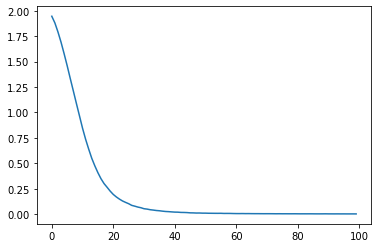

In [48]:
#import matplotlib.pyplot as plt
import seaborn as sns
losses_float=[float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices=[i for i, l in enumerate(losses_float)]
plt=sns.lineplot(loss_indices,losses_float)
plt

In [49]:
labels # 2708개의 라벨이 존재

tensor([0, 3, 2,  ..., 1, 6, 0])

테스트를 넣었을 때

In [59]:
test_losses=[]
model.eval()
test_labels=labels[idx_test]
output = model(features, adj)#모델에 피쳐와 인접행렬을 넣게되면 아웃풋이 나오게된다. 
loss=F.nll_loss(output[idx_test],test_labels)#모델에서 나온 테스트 아웃풋과 실제 라벨과 비교를 수행한다. 
test_losses.append(loss)
print(f"Test set ; accuracy: {accuracy(output[idx_test],test_labels)}; loss: {loss.item()}")

Test set ; accuracy: 0.799; loss: 0.6424875855445862


torch.Size([2708, 7])


<AxesSubplot:>

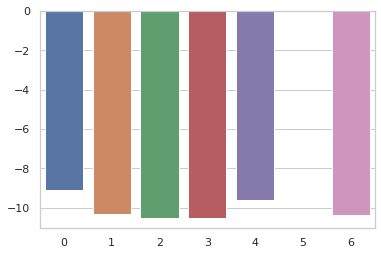

In [60]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(features, adj).shape)
pred = model(features, adj)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

In [61]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=70, 
                c=color.detach().cpu().numpy(), 
                cmap="Set2")
    fig.canvas.draw()

    # Convert to numpy
    return plt2arr(fig)


# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

TSNE Visualization finished.


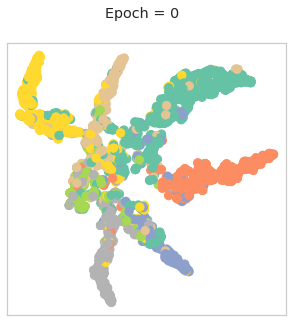

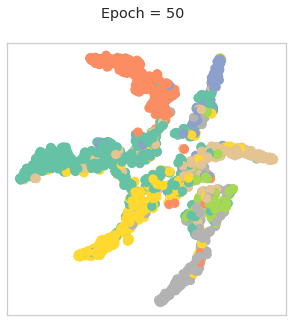

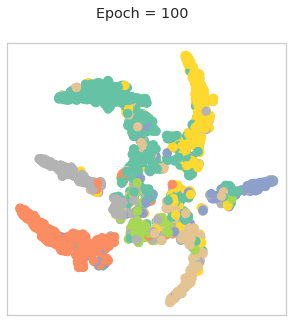

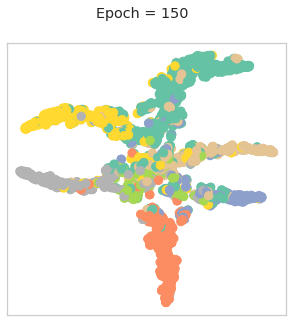

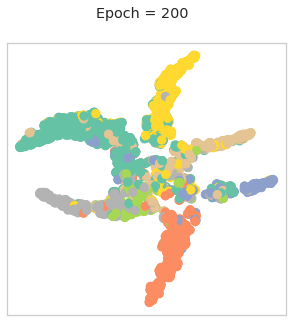

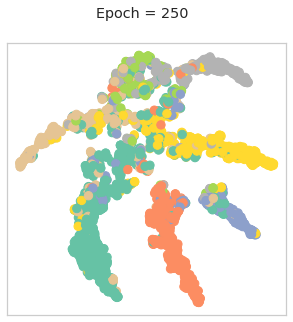

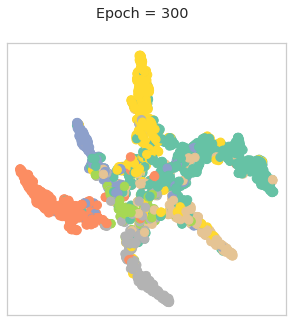

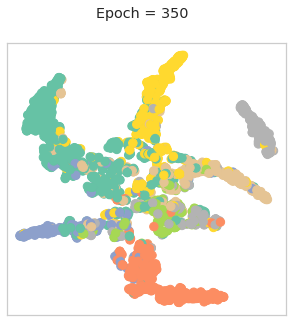

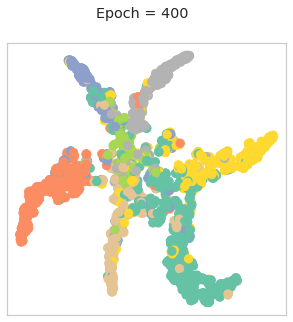

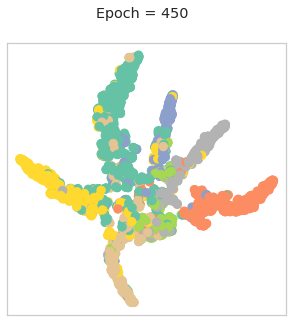

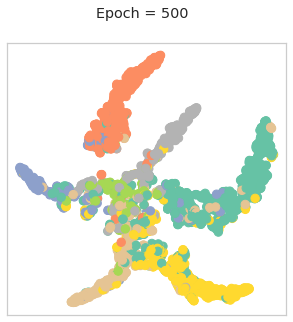

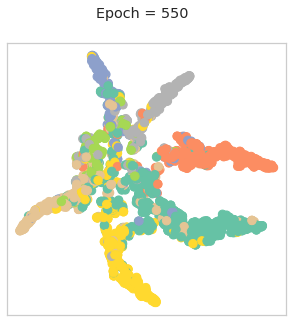

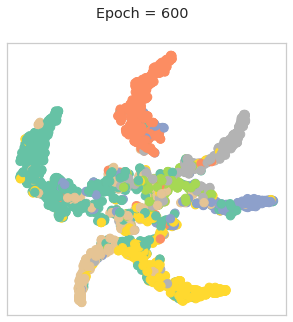

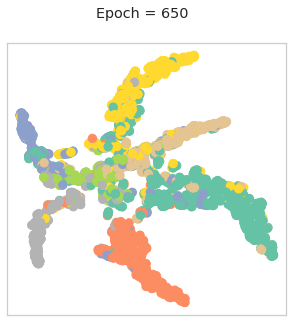

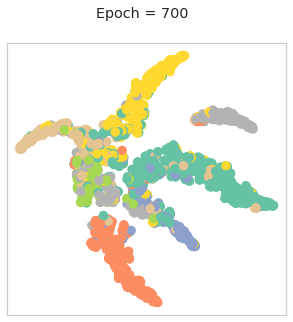

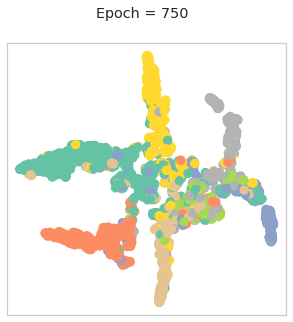

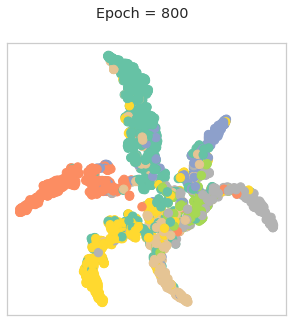

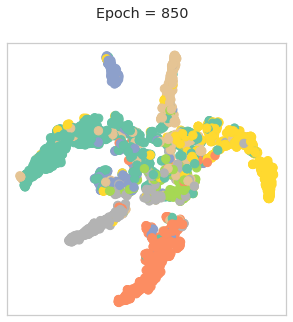

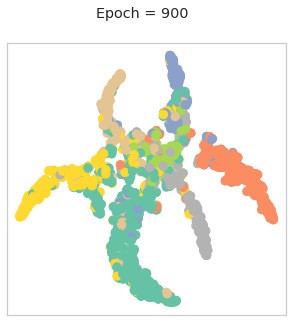

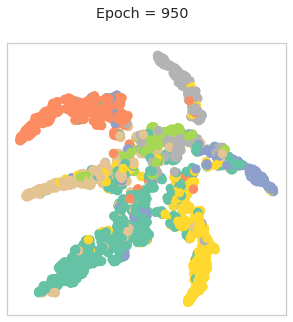

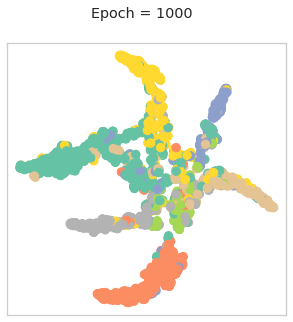

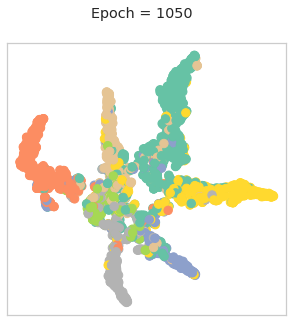

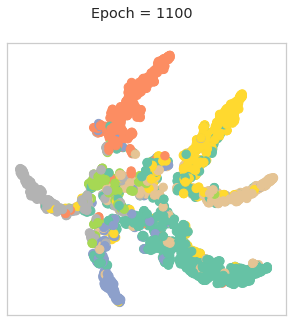

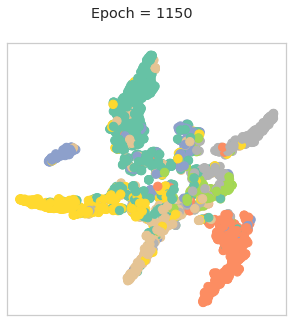

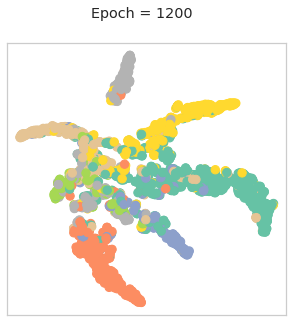

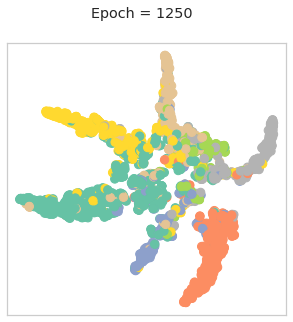

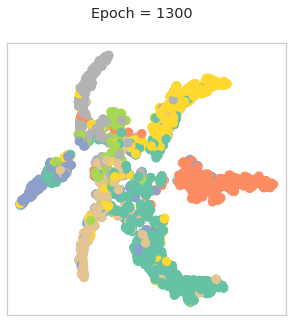

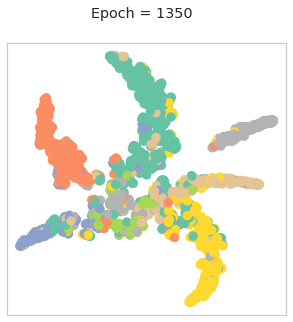

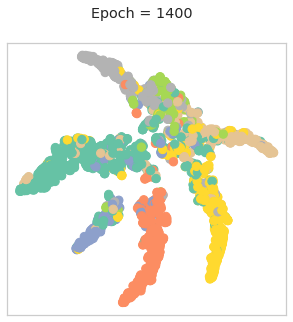

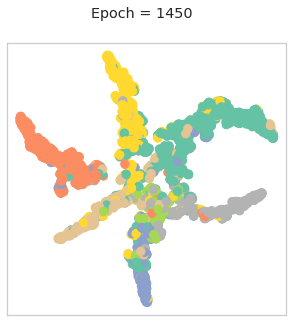

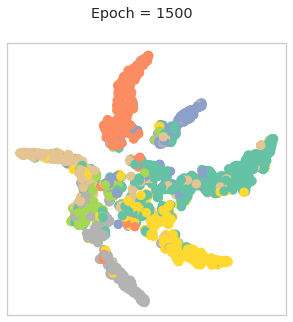

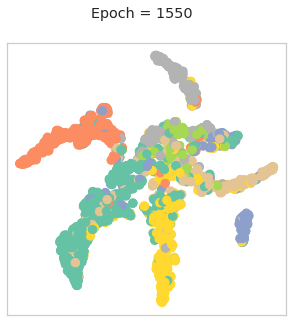

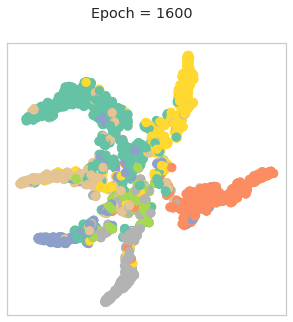

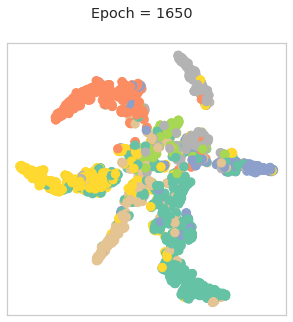

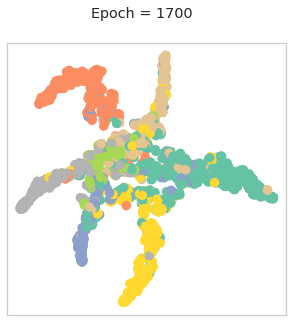

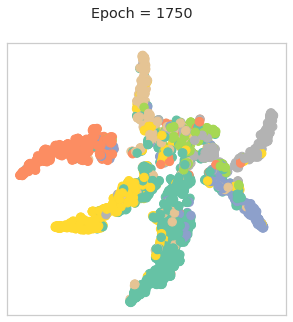

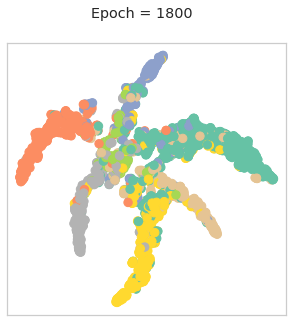

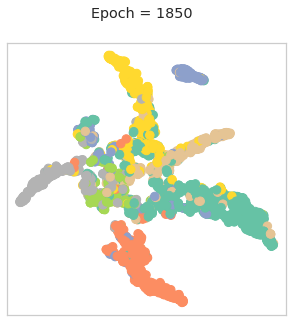

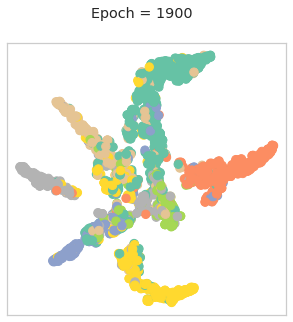

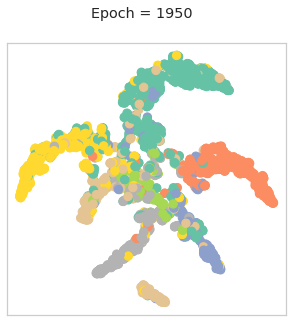

In [63]:
# Ignore deprecation warnings here
import warnings
warnings.filterwarnings('ignore')

# Train the model and save visualizations
images = []
for epoch in range(0, 2000):
    loss = model.train()
    if epoch % 50 == 0:
      out = model(features, adj)
      images.append(visualize(out, color=labels, epoch=epoch))
print("TSNE Visualization finished.")

In [64]:
from moviepy.editor import ImageSequenceClip
fps = 1
filename = "embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

MoviePy - Building file embeddings.gif with imageio.


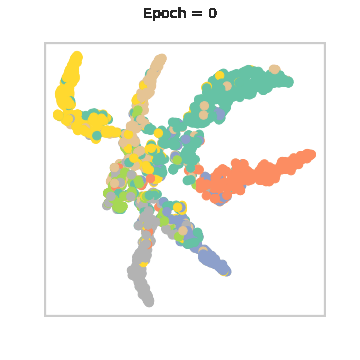

In [65]:
from IPython.display import Image
with open('embeddings.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

In [60]:
output[idx_test].shape#1000개의 클래스의 아웃풋이 소프트맥스로 나오기때문에 7개의 컬럼이 생기게된다.

torch.Size([1000, 7])

In [61]:
output_idx_test=output[idx_test]

In [64]:
df_output_idx_test=pd.DataFrame(output_idx_test.detach().numpy())
df_output_idx_test

,0,1,2,3,4,5,6
0,-0.756758,-4.771767,-3.789002,-0.712534,-5.772954,-5.772954,-5.772954
1,-3.717550,-5.247421,-0.068866,-3.756852,-5.605240,-5.605240,-5.070476
2,-7.970730,-7.242230,-4.056234,-0.019694,-7.970730,-7.970730,-7.739547
3,-3.929094,-6.279648,-0.034319,-5.207578,-6.279852,-6.279852,-5.816270
4,-4.015274,-3.365618,-4.389576,-0.079661,-5.242544,-5.714655,-5.808599
...,...,...,...,...,...,...,...
995,-0.146374,-4.046483,-2.956736,-3.107183,-5.054242,-4.839193,-4.870347
996,-10.221483,-10.902170,-10.763740,-10.902170,-8.985662,-0.000238,-10.902170
997,-5.738677,-5.849688,-6.298367,-5.368475,-5.364305,-0.018634,-6.742230
998,-3.054274,-3.415375,-3.377723,-2.154646,-1.315938,-0.764018,-3.327133


In [65]:
max(df_output_idx_test)

6

In [59]:
test_labels.shape

torch.Size([1000])

In [49]:
df_test_labels=pd.DataFrame(test_labels.numpy())
print(type(df_test_labels))
df_test_labels

<class 'pandas.core.frame.DataFrame'>


,0
0,3
1,2
2,3
3,2
4,2
...,...
995,0
996,5
997,5
998,5


In [12]:
model.eval()
test_labels=labels[idx_test]
output = model(features, adj)
loss=F.nll_loss(output[idx_test],test_labels)
print(f"Test set ; accuracy: {accuracy(output[idx_test],test_labels)}; loss: {loss.item()}")

Test set ; accuracy: 0.793; loss: 1.221176028251648
